In [1]:
import os
import numpy as np
import pickle
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
df_train = pd.read_excel('/mnt/dump/df_train.xlsx')
df_test = pd.read_excel('/mnt/dump/df_test.xlsx')

In [3]:
lbr = pickle.load(open('/mnt/dump/data/label_encoder.pickle','rb'))

In [ ]:
lbr.classes_

In [4]:
df_train.head()

,label,text,title
0,14,convent intern commiss rhine bern convent le g...,environmental_protection
1,14,convent intern commiss rhine bern convent le g...,pollution_control_measures
2,14,convent intern commiss rhine bern convent le g...,environmental_cooperation
4,14,convent intern commiss rhine bern convent le g...,ec_agreement
6,17,exchang letter commiss intern bureau weight me...,weights_and_measures


In [7]:
df_train['title'] = lbr.transform(df_train['title'])
df_test['title'] = lbr.transform(df_test['title'])

In [98]:
df_train.head()

,label,text,title
0,14,convent intern commiss rhine bern convent le g...,641
1,14,convent intern commiss rhine bern convent le g...,1424
2,14,convent intern commiss rhine bern convent le g...,637
4,14,convent intern commiss rhine bern convent le g...,526
6,17,exchang letter commiss intern bureau weight me...,1976


In [11]:
def load_res(name_pref=None):
    path = '/mnt/dump/final/'
    res_train = pickle.load(open(path+name_pref+'_train.pickle', 'rb'))
    res_test  = pickle.load(open(path+name_pref+'_test.pickle', 'rb'))
    print('Data load: done')
    return res_train, res_test

In [123]:
def transform_predict(label, p, classes):
    """
        label, p
        return:
            id_label: predcited_list
    """
    res = {}
    for c, single_label in tqdm(enumerate(label)):
        if single_label not in res:
            res[single_label] = p[c, :]
        if np.abs(res[single_label]-p[c, :]).sum()>1e-9:
            print(np.abs(res[single_label]-p[c, :]).sum())
            raise ValueError('bad')
    return res

def transform_test(df_truth, classes):
    """ y_label_aggregate
       	label	title
        0	53	1779
        1	53	559
        2	53	846
        
       return:
           id_label: one-hot y_list
    """
    if type(classes) is not list:
        classes = list(classes)
        
    res = {}
    for label, obj in tqdm(df_truth.groupby('label')):
        temp = np.zeros(len(classes))
        for single_class in obj['title']:
            temp[classes.index(single_class)] = 1
        res[label] = temp
    return res

def calculate_metric(dict_truth, dict_pred):
    if (len(set(dict_truth.keys())-set(dict_pred.keys()))!=0) or \
       (len(set(dict_pred.keys())-set(dict_truth.keys()))!=0):
            raise ValueError('labels mismatch')
            
    res_roc, res_ap = {}, {}
    for single_label in tqdm(set(dict_truth.keys())):
        p = dict_pred[single_label]
        y = dict_truth[single_label]
        res_roc[single_label] = roc_auc_score(y, p)
        res_ap[single_label] = average_precision_score(y, p)
    return res_roc, res_ap

def calculate(y_aggregate, p, classes):
    print('prepare truth')
    t_truth   = transform_test(y_aggregate, classes=classes)
    print('prepare predict')
    t_predict = transform_predict(y_aggregate['label'].get_values(), p, classes)
    print('calculate metric')
    res_roc, res_ap = calculate_metric(t_truth, t_predict)
    return res_roc, res_ap

# # t_truth   = transform_test(y_test_aggregate, classes=y_classes)
# # t_predict = transform_predict(y_label_test, res_test, y_classes)
# print('train')
# res_roc, res_ap = calculate(y_train_aggregate, res_train, classes=y_classes)
# print('ROC ', np.mean(list(res_roc.values())))
# print('AP  ', np.mean(list(res_ap.values())))
# print('done')

# print('test')
# res_roc, res_ap = calculate(y_test_aggregate, res_test, classes=y_classes)
# print('ROC ', np.mean(list(res_roc.values())))
# print('AP  ', np.mean(list(res_ap.values())))
# print('done')

In [114]:
# from sklearn.metrics import roc_auc_score, average_precision_score
# # from tqdm import tqdm

# # def calculate_metric(y_true, y_pred, y_label, classes):
# #     """
# #     return: ROC_AUC_LIST, AVERAGE_PRECISION_LIST
# #     """
# #     ROC_AUC_LIST = []
# #     AVERAGE_PRECISION_LIST = []
# # #     global y_true, classes, y_pred, y_label
# # #     y_true  = y_true#d['y_'+str(dtype)].get_values()
# # #     y_pred  = d['p_'+str(dtype)]
# # #     y_label = d['y_'+str(dtype)+'_label'].get_values()
# # #     classes = list(d['classes_'])
    
    
# #     for sample in tqdm(set(y_label)):
# #         ind = np.where(y_label == sample)[0]
# #         y_sample_truth = np.zeros(len(classes))
# #         try:
# #             index_of_labels = [classes.index(i) if i in classes else -1 for i in y_true[ind]]
# #             index_of_labels = list(filter(lambda x:x != -1, index_of_labels))
# #         except:
# #             print('not_in_list\t', y_true[ind], len(ind))
# #             continue
# #         y_sample_truth[index_of_labels] = 1
# #         p_sample = y_pred[ind[0], :]
        
# #         try:
# #             s_roc = roc_auc_score(y_sample_truth, p_sample)
# #             s_ap = average_precision_score(y_sample_truth, p_sample)
# #         except:
# #             print('label = ',i,'\nContinue')
            
# #         ROC_AUC_LIST.append(s_roc)
# #         AVERAGE_PRECISION_LIST.append(s_ap)
        
# #     return ROC_AUC_LIST, AVERAGE_PRECISION_LIST

In [108]:
y_test  = df_test['title'].get_values()
y_train = df_train['title'].get_values()

y_classes = np.array(list(sorted(set(y_test))))
y_label_test  = df_test['label'].get_values()
y_label_train = df_train['label'].get_values()

In [109]:
y_test[:10]
y_train[:10]

array([ 641, 1424,  637,  526, 1976, 1812, 1651,  877, 1792, 1499])

In [110]:
y_train_aggregate = pd.DataFrame({'label': y_label_train, 'title': y_train})
y_test_aggregate = pd.DataFrame({'label': y_label_test, 'title': y_test})
y_train_aggregate.head()

,label,title
0,14,641
1,14,1424
2,14,637
3,14,526
4,17,1976


count-vect + RF

In [115]:
res_train, res_test = load_res(name_pref='count_vect_rf')
print('train')
res_roc, res_ap = calculate(y_train_aggregate, res_train, classes=y_classes)
print('ROC ', np.mean(list(res_roc.values())))
print('AP  ', np.mean(list(res_ap.values())))
print('done')

print('test')
res_roc, res_ap = calculate(y_test_aggregate, res_test, classes=y_classes)
print('ROC ', np.mean(list(res_roc.values())))
print('AP  ', np.mean(list(res_ap.values())))
print('done')

done
train
prepare truth


100%|██████████| 17377/17377 [00:16<00:00, 1084.41it/s]
8377it [00:00, 83758.50it/s]

prepare predict


85219it [00:01, 81988.98it/s]
  0%|          | 59/17377 [00:00<00:29, 585.71it/s]

calculate metric


  6%|▋         | 121/1931 [00:00<00:01, 1206.41it/s]

ROC  0.9999799418568306
AP   0.9987357606495607
done
test
prepare truth


100%|██████████| 1931/1931 [00:01<00:00, 1238.97it/s]
10229it [00:00, 58032.96it/s]
  0%|          | 0/1931 [00:00<?, ?it/s]

prepare predict
calculate metric


100%|██████████| 1931/1931 [00:03<00:00, 582.61it/s]

ROC  0.7546968998209596
AP   0.3075651931425528
done


Tf-Idf + RF

In [124]:
res_test, res_train = load_res(name_pref='tf-idf') # misprint when save results,
print('train')
res_roc, res_ap = calculate(y_train_aggregate, res_train, classes=y_classes)
print('ROC ', np.mean(list(res_roc.values())))
print('AP  ', np.mean(list(res_ap.values())))
print('done')

print('test')
res_roc, res_ap = calculate(y_test_aggregate, res_test, classes=y_classes)
print('ROC ', np.mean(list(res_roc.values())))
print('AP  ', np.mean(list(res_ap.values())))
print('done')

done
train
prepare truth


100%|██████████| 17377/17377 [00:16<00:00, 1063.08it/s]
7104it [00:00, 71038.37it/s]

prepare predict


85219it [00:01, 70255.43it/s]
  0%|          | 51/17377 [00:00<00:34, 502.45it/s]

calculate metric


  5%|▌         | 103/1931 [00:00<00:01, 1024.45it/s]

ROC  0.9999616781827476
AP   0.9986121067475677
done
test
prepare truth


100%|██████████| 1931/1931 [00:01<00:00, 1046.86it/s]
10229it [00:00, 51780.59it/s]

prepare predict



  2%|▏         | 47/1931 [00:00<00:04, 466.05it/s]

calculate metric


100%|██████████| 1931/1931 [00:03<00:00, 504.10it/s]

ROC  0.7532594150112648
AP   0.297674106771554
done


#### Word2Vec (our)

In [125]:
res_test, res_train = load_res(name_pref='word2vect_our') # misprint when save results,
print('train')
res_roc, res_ap = calculate(y_train_aggregate, res_train, classes=y_classes)
print('ROC ', np.mean(list(res_roc.values())))
print('AP  ', np.mean(list(res_ap.values())))
print('done')

print('test')
res_roc, res_ap = calculate(y_test_aggregate, res_test, classes=y_classes)
print('ROC ', np.mean(list(res_roc.values())))
print('AP  ', np.mean(list(res_ap.values())))
print('done')

done
train
prepare truth


100%|██████████| 17377/17377 [00:16<00:00, 1062.54it/s]
7218it [00:00, 72177.32it/s]

prepare predict


85219it [00:01, 73939.66it/s]
  0%|          | 51/17377 [00:00<00:34, 508.51it/s]

calculate metric


  5%|▌         | 103/1931 [00:00<00:01, 1023.41it/s]

ROC  0.9999783476477072
AP   0.9993915716941449
done
test
prepare truth


100%|██████████| 1931/1931 [00:01<00:00, 1027.82it/s]
10229it [00:00, 52037.65it/s]
  0%|          | 0/1931 [00:00<?, ?it/s]

prepare predict
calculate metric


100%|██████████| 1931/1931 [00:03<00:00, 513.26it/s]

ROC  0.7469967012596413
AP   0.27351119401116275
done


##### Word2Vect (google)

In [126]:
res_test, res_train = load_res(name_pref='word2vect_google_news') # misprint when save results,
print('train')
res_roc, res_ap = calculate(y_train_aggregate, res_train, classes=y_classes)
print('ROC ', np.mean(list(res_roc.values())))
print('AP  ', np.mean(list(res_ap.values())))
print('done')

print('test')
res_roc, res_ap = calculate(y_test_aggregate, res_test, classes=y_classes)
print('ROC ', np.mean(list(res_roc.values())))
print('AP  ', np.mean(list(res_ap.values())))
print('done')

done
train
prepare truth


100%|██████████| 17377/17377 [00:23<00:00, 737.68it/s] 
4565it [00:00, 45641.77it/s]

prepare predict


85219it [00:01, 46889.00it/s]
  0%|          | 34/17377 [00:00<00:52, 331.73it/s]

calculate metric


  5%|▌         | 105/1931 [00:00<00:01, 1046.04it/s]

ROC  0.999981500431548
AP   0.9992350922300626
done
test
prepare truth


100%|██████████| 1931/1931 [00:01<00:00, 1003.93it/s]
10229it [00:00, 53615.35it/s]
  0%|          | 0/1931 [00:00<?, ?it/s]

prepare predict
calculate metric


100%|██████████| 1931/1931 [00:03<00:00, 498.98it/s]

ROC  0.7179403852652685
AP   0.22118009257703494
done


In [122]:
# t_truth[14].shape, t_predict[14].shape
res_train.shape

(10229, 2007)

100%|██████████| 1931/1931 [00:03<00:00, 487.43it/s]


In [101]:
np.mean(list(res_roc.values())), np.mean(list(res_ap.values()))

(0.5001157260039326, 0.004291158565114708)

In [70]:
set(t_truth.keys()) -  set(t_predict.keys())

set()

In [56]:
y_label_test

array([   53,    53,    53, ..., 19940, 19940, 19940])

In [ ]:
#### count-vect + RF

In [128]:
1

1

In [29]:
ROC_AUC_LIST, AVERAGE_PRECISION_LIST = calculate_metric(y_test, res_test, y_label,y_classes)

  5%|▌         | 105/2007 [00:00<00:01, 1042.02it/s]

not_in_list	 ['1779'] 1
not_in_list	 ['559'] 1
not_in_list	 ['846' '429' '526' '1109'] 4
not_in_list	 ['1859'] 1
not_in_list	 ['1855' '437' '1499' '527' '1248' '1983'] 6
not_in_list	 ['1859' '526' '1779' '136' '345' '1861'] 6
not_in_list	 ['1182'] 1
not_in_list	 ['1229' '1034' '877' '1044' '679' '1981' '1491'] 7
not_in_list	 ['1493' '842' '178' '1856' '570' '1957' '1623' '1674' '886' '1195' '1530'
 '207' '526' '1307' '1747' '1921' '788' '207' '637' '789' '1304' '526'
 '345' '1790' '788' '526' '905' '796' '789'] 29
not_in_list	 ['534'] 1
not_in_list	 ['1916' '637' '1005' '1033'] 4
not_in_list	 ['432'] 1
not_in_list	 ['434' '1920' '1125'] 3
not_in_list	 ['1304' '1651' '1812' '1356'] 4
not_in_list	 ['534' '1856'] 2
not_in_list	 ['570' '559' '234'] 3
not_in_list	 ['387' '526' '570'] 3
not_in_list	 ['526' '1779'] 2
not_in_list	 ['560' '636' '1304' '489' '560' '636' '1779' '489' '1005' '1395' '1589'
 '526' '826' '1109' '1794' '1499'] 16
not_in_list	 ['534'] 1
not_in_list	 ['1905'] 1
not_in_l

 17%|█▋        | 336/2007 [00:00<00:01, 1096.75it/s]

3
not_in_list	 ['641' '1318' '1183' '1408' '682' '1964' '1055' '1045' '313' '1509' '639'
 '722' '1621' '1739' '220'] 15
not_in_list	 ['1897'] 1
not_in_list	 ['682'] 1
not_in_list	 ['1005'] 1
not_in_list	 ['682' '1842' '306' '432' '1947' '1406' '1492' '1890' '1948' '922' '87'
 '886' '923' '1674' '1054' '1947' '150' '759' '368' '146' '1518' '308'
 '1737' '1955' '973' '1482' '61' '66' '1272' '1695' '52' '1739' '682'] 33
not_in_list	 ['53' '582' '45' '1033' '1042' '1327' '1446' '1785' '963' '249' '444'
 '971' '1478' '1352' '1198' '957' '261' '658' '389'] 19
not_in_list	 ['335' '18' '816' '1390' '239' '94'] 6
not_in_list	 ['868'] 1
not_in_list	 ['1935' '1850'] 2
not_in_list	 ['823'] 1
not_in_list	 ['1509'] 1
not_in_list	 ['1250' '1392'] 2
not_in_list	 ['473' '1469' '658'] 3
not_in_list	 ['1446' '1346' '966' '255' '1907' '922' '1402' '1314' '898' '411' '1842'
 '528' '1417' '335' '8' '772' '526' '607' '1591' '1527' '1918' '1176'
 '1267' '1470' '990' '1694' '527' '1499' '113'] 29
not_in_list	 

 34%|███▍      | 680/2007 [00:00<00:01, 1119.21it/s]

not_in_list	 ['861' '323' '2002' '1194'] 4
not_in_list	 ['1917'] 1
not_in_list	 ['1033' '1822'] 2
not_in_list	 ['496'] 1
not_in_list	 ['1599' '1724' '1186' '1233' '742' '1023' '969' '847' '990' '1125' '1346'
 '255' '160' '1737' '1067'] 15
not_in_list	 ['1062'] 1
not_in_list	 ['65' '1252' '1681' '287' '1632' '1940' '1183' '1932' '710' '221' '1045'
 '1805' '115' '82' '817' '1838' '826' '1469' '115' '1816' '533' '311'
 '1192' '605' '1779' '550' '554'] 27
not_in_list	 ['877' '294' '1272' '1089' '29' '537' '1115' '1111' '843' '1542' '1886'
 '25' '585'] 13
not_in_list	 ['1068' '1067'] 2
not_in_list	 ['1676' '804'] 2
not_in_list	 ['1167' '1426' '335' '1446' '1203' '1499' '1680' '1737' '1250' '783'
 '1203' '1656' '892' '1121' '519' '1737' '38' '937' '1727' '1633' '1370'
 '992'] 22
not_in_list	 ['711'] 1
not_in_list	 ['1599' '711' '489' '544' '1253' '362' '1655' '1301' '227' '782'] 10
not_in_list	 ['228'] 1
not_in_list	 ['402' '1676' '178' '726' '101' '104'] 6
not_in_list	 ['1932' '1386' '1796'

 45%|████▌     | 913/2007 [00:00<00:00, 1140.80it/s]

not_in_list	 ['62'] 1
not_in_list	 ['1688'] 1
not_in_list	 ['1227' '820' '1185' '1674' '1561' '861' '216' '264' '47' '265' '811'
 '618' '2002' '23' '1346' '136' '526' '1495' '71' '1055' '222' '73' '1176'
 '1885' '538' '1684' '325' '433' '435' '1113' '1050' '427' '718' '298'
 '23' '1346' '1304' '526' '1495' '1135' '239' '503' '1571' '581' '1621'
 '1895' '1871' '115' '692' '558' '1371' '1380' '1576' '2' '1842' '1720'
 '1054' '1870' '294' '149' '269' '960' '1182' '721' '558' '1576' '1874'
 '1554' '692' '1082' '1653' '1028' '1818' '526' '1034' '1927' '1593' '516'
 '756' '1730' '557' '1836' '270' '1924' '353'] 85
not_in_list	 ['983' '410'] 2
not_in_list	 ['1694' '398'] 2
not_in_list	 ['1592' '1651' '335'] 3
not_in_list	 ['1183'] 1
not_in_list	 ['923' '244' '781' '116' '837' '331' '1704' '1220'] 8
not_in_list	 ['1066'] 1
not_in_list	 ['923' '780'] 2
not_in_list	 ['1655' '1720' '1168'] 3
not_in_list	 ['854' '1173' '1272'] 3
not_in_list	 ['1621' '1871' '837' '1005' '115' '1618' '620' '66' '173

 58%|█████▊    | 1159/2007 [00:01<00:00, 1186.38it/s]

['276' '1695' '1609' '335' '1005' '1582' '1607' '962' '850' '1221' '621'
 '333' '1222' '1842' '31' '833' '333' '1663' '1222' '31' '621' '1842'
 '170' '1509'] 24
not_in_list	 ['1470'] 1
not_in_list	 ['1665'] 1
not_in_list	 ['115'] 1
not_in_list	 ['287'] 1
not_in_list	 ['465' '1252'] 2
not_in_list	 ['1681'] 1
not_in_list	 ['1720' '575' '1703' '342' '525' '786' '922' '966' '1183' '923' '120'
 '1499' '1837' '522' '559' '559' '547' '882' '389' '353' '1124' '1820'
 '1858' '1431' '774' '1751' '324' '343' '1066' '249' '1269' '1502' '534'
 '1918' '191' '363' '115' '1816' '1527' '533' '353' '465' '1124'] 43
not_in_list	 ['1820' '892' '658' '1273' '1964' '444' '1355' '1005' '115' '287' '465'
 '1252' '1681' '1146' '115' '287' '465' '1252' '1681' '1917' '419' '651'
 '922' '923' '1725' '1827' '57' '61' '872' '1472' '1074' '87' '116' '780'
 '923' '1655' '1066' '297' '353' '567' '1820' '682' '641' '1033' '1034'
 '1509' '1926' '1972' '943' '1466' '1556' '160' '1457' '1517' '1522'
 '1683' '1986' '525' '

 64%|██████▎   | 1276/2007 [00:01<00:00, 1111.20it/s]

1
not_in_list	 ['658'] 1
not_in_list	 ['540' '837' '852' '1664' '1704'] 5
not_in_list	 ['1960' '658' '87' '926' '1003'] 5
not_in_list	 ['1005'] 1
not_in_list	 ['1948'] 1
not_in_list	 ['365'] 1
not_in_list	 ['377' '407' '1005' '1087'] 4
not_in_list	 ['469' '1158'] 2
not_in_list	 ['15'] 1
not_in_list	 ['531'] 1
not_in_list	 ['587' '676' '658' '575' '34'] 5
not_in_list	 ['115' '374' '826' '1094' '1354'] 5
not_in_list	 ['82' '92' '816' '1953' '641' '1965' '1938' '1961' '1964' '699' '623'
 '629'] 12
not_in_list	 ['1128'] 1
not_in_list	 ['1813'] 1
not_in_list	 ['699' '533' '641' '1963' '1964' '673' '831' '235'] 8
not_in_list	 ['215' '1271' '1918' '1075' '663' '966' '1181' '1346' '1530' '1837' '1842'
 '47' '786' '1163' '1793' '1837' '877' '101' '966'] 19
not_in_list	 ['1403' '1904'] 2
not_in_list	 ['410'] 1
not_in_list	 ['1910' '92' '810' '827'] 4
not_in_list	 ['57' '966'] 2
not_in_list	 ['1346' '1793' '1779' '92' '810' '827'] 6
not_in_list	 ['1838' '860' '1185' '1469' '1744' '860' '1185' '14

 75%|███████▍  | 1503/2007 [00:01<00:00, 1119.84it/s]

3
not_in_list	 ['211' '658'] 2
not_in_list	 ['1485' '93' '1778'] 3
not_in_list	 ['1980' '1930' '1631' '1300' '1605' '1523'] 6
not_in_list	 ['1930'] 1
not_in_list	 ['1074'] 1
not_in_list	 ['1489'] 1
not_in_list	 ['87' '923'] 2
not_in_list	 ['1947' '308' '18' '1931' '1751' '471' '773' '1564' '469'] 9
not_in_list	 ['320'] 1
not_in_list	 ['61'] 1
not_in_list	 ['883'] 1
not_in_list	 ['756' '93' '1778' '308' '181' '229' '1778' '1135' '926'] 9
not_in_list	 ['658'] 1
not_in_list	 ['389'] 1
not_in_list	 ['936'] 1
not_in_list	 ['335' '1693'] 2
not_in_list	 ['1532' '1143'] 2
not_in_list	 ['843' '1194'] 2
not_in_list	 ['1890' '1947'] 2
not_in_list	 ['465'] 1
not_in_list	 ['923' '1768' '1691'] 3
not_in_list	 ['843' '1146' '883' '93' '1778' '923' '1737' '883'] 8
not_in_list	 ['1679'] 1
not_in_list	 ['1564' '1058'] 2
not_in_list	 ['1737' '883'] 2
not_in_list	 ['386'] 1
not_in_list	 ['354'] 1
not_in_list	 ['220' '1862' '1886' '1693' '1362'] 5
not_in_list	 ['1405' '1407' '1406' '1493' '1005' '487' '175

 87%|████████▋ | 1741/2007 [00:01<00:00, 1154.85it/s]

not_in_list	 ['229'] 1
not_in_list	 ['1947'] 1
not_in_list	 ['923' '1133'] 2
not_in_list	 ['87'] 1
not_in_list	 ['1792' '724' '1793' '429' '47' '57' '966' '718' '1346' '1693' '811' '239'
 '298' '900' '1411' '1471' '1954' '1467' '466' '1333' '892' '1143' '923'
 '1054' '966' '86' '1133' '922' '296'] 29
not_in_list	 ['791'] 1
not_in_list	 ['801'] 1
not_in_list	 ['1815'] 1
not_in_list	 ['721'] 1
not_in_list	 ['245'] 1
not_in_list	 ['1918'] 1
not_in_list	 ['1793' '877' '718' '432' '1068'] 5
not_in_list	 ['1629'] 1
not_in_list	 ['559' '1346' '799' '1655' '1677' '1285' '346'] 7
not_in_list	 ['1040' '578'] 2
not_in_list	 ['832' '71'] 2
not_in_list	 ['1863'] 1
not_in_list	 ['1833'] 1
not_in_list	 ['37'] 1
not_in_list	 ['1030' '243' '799'] 3
not_in_list	 ['417' '1677' '346' '160' '529'] 5
not_in_list	 ['1171'] 1
not_in_list	 ['765'] 1
not_in_list	 ['4' '685' '765' '4'] 4
not_in_list	 ['691' '765'] 2
not_in_list	 ['4' '701'] 2
not_in_list	 ['1322' '4' '133' '758' '670' '4' '765' '342' '350' '177'

100%|██████████| 2007/2007 [00:01<00:00, 1137.41it/s]

3
not_in_list	 ['1252' '287' '1965' '1212' '1253' '1721'] 6
not_in_list	 ['533' '1854' '55' '1632' '311' '833' '1595' '1653' '31' '658'] 10
not_in_list	 ['1590' '1408'] 2
not_in_list	 ['1397' '1185' '641' '1389' '1633' '1177' '694' '1626' '1576' '692' '558'
 '1380' '1877' '1698' '1026' '826' '377' '823' '1509' '1850' '822' '250'
 '101' '255' '300' '1812' '1223' '124' '1040' '243' '203' '1793' '1266'
 '1444' '968' '560' '230' '15' '1031' '979' '662' '209' '966' '282' '76'
 '1779' '1126' '47' '718' '1982' '82' '871' '75' '1469' '1389' '411' '826'
 '92'] 58
not_in_list	 ['94'] 1
not_in_list	 ['699'] 1
not_in_list	 ['822'] 1
not_in_list	 ['1509' '827'] 2
not_in_list	 ['101'] 1
not_in_list	 ['1839'] 1
not_in_list	 ['966' '1403'] 2
not_in_list	 ['102' '101' '966' '1412' '1346' '255' '102' '1581' '1413' '1173' '1886'
 '370'] 12
not_in_list	 ['354' '1061' '1704' '1699'] 4
not_in_list	 ['347' '734' '1701'] 3
not_in_list	 ['497'] 1
not_in_list	 ['466' '1431' '941' '1143'] 4
not_in_list	 ['1467' 

In [30]:
ROC_AUC_LIST

[]

In [93]:
DIRTY_DUMP_PATH = "/mnt/dump/dirty_dump_new/"
EMBEDING_DUMP_PATH = '/mnt/dump/dump_embedings_new/'
# DUMP = 'dump_embedings'
N_CV = 10

In [94]:
files = [DIRTY_DUMP_PATH+i for i in os.listdir(DIRTY_DUMP_PATH)]

In [16]:
fn = files[0]
d = pickle.load(open(fn, 'rb'))

In [17]:
d.keys()

dict_keys(['y_train_label', 'y_test_label', 'y_train', 'y_test', 'p_test', 'classes_', 'p_train'])

In [19]:
d['y_test_label'].nunique()

5102

In [62]:
#Classes loaded wrong
data = pd.read_excel('/mnt/dump/data.xlsx')

In [67]:
classes = list(data['title'].unique())

In [95]:
# classes.index('1')

In [84]:
from sklearn.metrics import roc_auc_score, average_precision_score
from tqdm import tqdm

def calculate_metric(d, dtype='test'):
    """
    return: ROC_AUC_LIST, AVERAGE_PRECISION_LIST
    """
    ROC_AUC_LIST = []
    AVERAGE_PRECISION_LIST = []
    global y_true, classes, y_pred, y_label
    y_true  = d['y_'+str(dtype)].get_values()
    y_pred  = d['p_'+str(dtype)]
    y_label = d['y_'+str(dtype)+'_label'].get_values()
    classes = list(d['classes_'])
    
    
    for sample in tqdm(set(y_label)):
        ind = np.where(y_label == sample)[0]
        y_sample_truth = np.zeros(len(classes))
        try:
            index_of_labels = [classes.index(i) if i in classes else -1 for i in y_true[ind]]
            index_of_labels = list(filter(lambda x:x != -1, index_of_labels))
        except:
            print('not_in_list\t', y_true[ind], len(ind))
            continue
        y_sample_truth[index_of_labels] = 1
        p_sample = y_pred[ind[0], :]
        
        try:
            s_roc = roc_auc_score(y_sample_truth, p_sample)
            s_ap = average_precision_score(y_sample_truth, p_sample)
        except:
            print('label = ',i,'\nContinue')
            
        ROC_AUC_LIST.append(s_roc)
        AVERAGE_PRECISION_LIST.append(s_ap)
        
    return ROC_AUC_LIST, AVERAGE_PRECISION_LIST
#     Proof of work
#     global p_sample
#         p_sample = []
#         for k in ind:
#             p_sample.append(y_pred[k, :])
#             plt.plot(p_sample[-1], alpha = 0.5)
#         plt.yscale('log')
#         plt.show()
        
#         print(y_true[ind])
#         print(1/0)
a, b = calculate_metric(d)


 76%|███████▌  | 3889/5102 [00:12<00:03, 388.92it/s]

label =  5 
Continue



 97%|█████████▋| 4949/5102 [00:15<00:00, 387.83it/s]

label =  5 
Continue



100%|██████████| 5102/5102 [00:15<00:00, 320.49it/s]

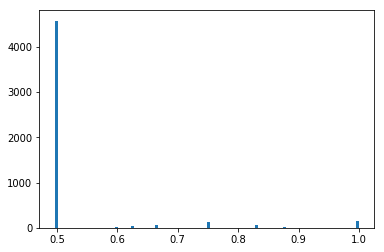

In [88]:
plt.hist(a, bins = 100)
plt.show()

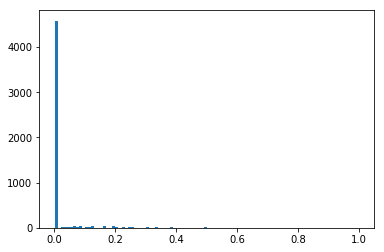

In [89]:
plt.hist(b, bins = 100)
plt.show()

In [91]:
np.mean(a)
np.mean(b)

0.021189723918261072

In [31]:
np.array([1,2,3])

array([1, 2, 3])

In [53]:
for i in range(len(p_sample)):
    for k in range(len(p_sample)):
        print(i,k, np.abs(p_sample[i]-p_sample[k]).sum())

0 0 0.0
0 1 0.0
0 2 0.0
0 3 0.0
0 4 0.0
0 5 0.0
1 0 0.0
1 1 0.0
1 2 0.0
1 3 0.0
1 4 0.0
1 5 0.0
2 0 0.0
2 1 0.0
2 2 0.0
2 3 0.0
2 4 0.0
2 5 0.0
3 0 0.0
3 1 0.0
3 2 0.0
3 3 0.0
3 4 0.0
3 5 0.0
4 0 0.0
4 1 0.0
4 2 0.0
4 3 0.0
4 4 0.0
4 5 0.0
5 0 0.0
5 1 0.0
5 2 0.0
5 3 0.0
5 4 0.0
5 5 0.0


In [82]:
a = [1 if i%2==0 else -1  for i in range(10)]
a.remove(-1)
a

[1, 1, -1, 1, -1, 1, -1, 1, -1]

In [129]:
"""fast text results"""

def transform_predict(label, p, classes):
    """
        label, p
        return:
            id_label: predcited_list
    """
    res = {}
    for c, single_label in tqdm(enumerate(label)):
        if single_label not in res:
            res[single_label] = p[c, :]
        if np.abs(res[single_label]-p[c, :]).sum()>1e-9:
            print(np.abs(res[single_label]-p[c, :]).sum())
            raise ValueError('bad')
    return res

def transform_test(df_truth, classes):
    """ y_label_aggregate
       	label	title
        0	53	1779
        1	53	559
        2	53	846
        
       return:
           id_label: one-hot y_list
    """
    if type(classes) is not list:
        classes = list(classes)
        
    res = {}
    for label, obj in tqdm(df_truth.groupby('label')):
        temp = np.zeros(len(classes))
        for single_class in obj['title']:
            temp[classes.index(single_class)] = 1
        res[label] = temp
    return res

def calculate_metric(dict_truth, dict_pred):
    if (len(set(dict_truth.keys())-set(dict_pred.keys()))!=0) or \
       (len(set(dict_pred.keys())-set(dict_truth.keys()))!=0):
            raise ValueError('labels mismatch')
            
    res_roc, res_ap = {}, {}
    for single_label in tqdm(set(dict_truth.keys())):
        p = dict_pred[single_label]
        y = dict_truth[single_label]
        res_roc[single_label] = roc_auc_score(y, p)
        res_ap[single_label] = average_precision_score(y, p)
    return res_roc, res_ap

def calculate(y_aggregate, p, classes):
    print('prepare truth')
    t_truth   = transform_test(y_aggregate, classes=classes)
    print('prepare predict')
    t_predict = transform_predict(y_aggregate['label'].get_values(), p, classes)
    print('calculate metric')
    res_roc, res_ap = calculate_metric(t_truth, t_predict)
    return res_roc, res_ap

# # t_truth   = transform_test(y_test_aggregate, classes=y_classes)
# # t_predict = transform_predict(y_label_test, res_test, y_classes)
# print('train')
# res_roc, res_ap = calculate(y_train_aggregate, res_train, classes=y_classes)
# print('ROC ', np.mean(list(res_roc.values())))
# print('AP  ', np.mean(list(res_ap.values())))
# print('done')

# print('test')
# res_roc, res_ap = calculate(y_test_aggregate, res_test, classes=y_classes)
# print('ROC ', np.mean(list(res_roc.values())))
# print('AP  ', np.mean(list(res_ap.values())))
# print('done')

import pickle
import numpy as np
import pandas as pd
res = pickle.load(open('/mnt/dump/dirty_dump/fasttext|fast_text|0','rb'))

y_agg_train = pd.DataFrame({'title': res['y_train'],
                            'label': res['y_train_label']})
p_train = res['p_train']

y_agg_test = pd.DataFrame({'title': res['y_test'],
                           'label': res['y_test_label']})
p_test = res['p_test']

classes = res['classes_']


print('train')
res_roc, res_ap = calculate(y_agg_train, p_train, classes=classes)
print('ROC ', np.mean(list(res_roc.values())))
print('AP  ', np.mean(list(res_ap.values())))
print('done')

print('test')
res_roc, res_ap = calculate(y_agg_test, p_test, classes=classes)
print('ROC ', np.mean(list(res_roc.values())))
print('AP  ', np.mean(list(res_ap.values())))
print('done')

train
prepare truth


100%|██████████| 19308/19308 [00:09<00:00, 2062.94it/s]
4963it [00:00, 49628.86it/s]

prepare predict


92466it [00:02, 44967.38it/s]
  0%|          | 32/19308 [00:00<01:00, 318.74it/s]

calculate metric


100%|██████████| 19308/19308 [00:54<00:00, 351.48it/s]


ROC  0.5016290316372537
AP   0.002835192132391308
done
test
prepare truth


100%|██████████| 8151/8151 [00:02<00:00, 2901.81it/s]
9638it [00:00, 47389.67it/s]

prepare predict


10275it [00:00, 47644.21it/s]
  0%|          | 34/8151 [00:00<00:24, 331.02it/s]

calculate metric


100%|██████████| 8151/8151 [00:23<00:00, 352.87it/s]

ROC  0.49575258399423194
AP   0.0018443614500961263
done


In [133]:
df_train = pd.read_excel('/mnt/dump/df_train.xlsx')
df_test  = pd.read_excel('/mnt/dump/df_test.xlsx')

In [144]:
"""fast text results"""

def transform_predict(label, p, classes):
    """
        label, p
        return:
            id_label: predcited_list
    """
    res = {}
    for c, single_label in tqdm(enumerate(label)):
        if single_label not in res:
            res[single_label] = p[c, :]
        if np.abs(res[single_label]-p[c, :]).sum()>1e-9:
            print(np.abs(res[single_label]-p[c, :]).sum())
            raise ValueError('bad')
            
    return res

def transform_test(df_truth, classes):
    """ y_label_aggregate
       	label	title
        0	53	1779
        1	53	559
        2	53	846
        
       return:
           id_label: one-hot y_list
    """
    if type(classes) is not list:
        classes = list(classes)
        
    res = {}
    for label, obj in tqdm(df_truth.groupby('label')):
        temp = np.zeros(len(classes))
        for single_class in obj['title']:
            temp[classes.index(single_class)] = 1
        res[label] = temp
    return res

def calculate_metric(dict_truth, dict_pred):
    if (len(set(dict_truth.keys())-set(dict_pred.keys()))!=0) or \
       (len(set(dict_pred.keys())-set(dict_truth.keys()))!=0):
            raise ValueError('labels mismatch')
            
    res_roc, res_ap = {}, {}
    for single_label in tqdm(set(dict_truth.keys())):
        p = dict_pred[single_label]
        y = dict_truth[single_label]
        res_roc[single_label] = roc_auc_score(y, p)
        res_ap[single_label] = average_precision_score(y, p)
    return res_roc, res_ap

def calculate(y_aggregate, p, classes):
    print('prepare truth')
    t_truth   = transform_test(y_aggregate, classes=classes)
    print('prepare predict')
    t_predict = transform_predict(y_aggregate['label'].get_values(), p, classes)
    print('calculate metric')
    res_roc, res_ap = calculate_metric(t_truth, t_predict)
    return res_roc, res_ap

# # t_truth   = transform_test(y_test_aggregate, classes=y_classes)
# # t_predict = transform_predict(y_label_test, res_test, y_classes)
# print('train')
# res_roc, res_ap = calculate(y_train_aggregate, res_train, classes=y_classes)
# print('ROC ', np.mean(list(res_roc.values())))
# print('AP  ', np.mean(list(res_ap.values())))
# print('done')

# print('test')
# res_roc, res_ap = calculate(y_test_aggregate, res_test, classes=y_classes)
# print('ROC ', np.mean(list(res_roc.values())))
# print('AP  ', np.mean(list(res_ap.values())))
# print('done')

import pickle
import numpy as np
import pandas as pd
res = pickle.load(open('/mnt/dump/dirty_dump/fasttext|fast_text|1','rb'))

y_agg_train = df_train
# pd.DataFrame({'title': res['y_train'],
#                             'label': res['y_train_label']})
p_train = res['p_train']

y_agg_test = df_test
# pd.DataFrame({'title': res['y_test'],
#                            'label': res['y_test_label']})
p_test = res['p_test']

classes = res['classes']


print('train')
res_roc, res_ap = calculate(y_agg_train, p_train, classes=classes)
print('ROC ', np.mean(list(res_roc.values())))
print('AP  ', np.mean(list(res_ap.values())))
print('done')

print('test')
res_roc, res_ap = calculate(y_agg_test, p_test, classes=classes)
print('ROC ', np.mean(list(res_roc.values())))
print('AP  ', np.mean(list(res_ap.values())))
print('done')

train
prepare truth


100%|██████████| 17377/17377 [00:06<00:00, 2588.28it/s]
5206it [00:00, 52059.06it/s]

prepare predict


85219it [00:01, 50872.36it/s]
  0%|          | 35/17377 [00:00<00:50, 346.08it/s]

calculate metric


 26%|██▋       | 507/1931 [00:00<00:00, 2592.80it/s]

ROC  0.49672026411311354
AP   0.0026859449119205196
done
test
prepare truth


100%|██████████| 1931/1931 [00:00<00:00, 2239.41it/s]
5110it [00:00, 51097.12it/s]

prepare predict


10229it [00:00, 50148.72it/s]
  2%|▏         | 36/1931 [00:00<00:05, 359.30it/s]

calculate metric


100%|██████████| 1931/1931 [00:06<00:00, 311.52it/s]

ROC  0.4992807140035048
AP   0.0026040317124421983
done


In [143]:
res['p_train']

array([[0.        , 0.        , 0.        , ..., 0.00022874, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00022874, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00022874, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00018922, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00018922, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00018922, 0.        ,
        0.        ]])

In [139]:
df_train

,label,text,title
0,14,convent intern commiss rhine bern convent le g...,environmental_protection
1,14,convent intern commiss rhine bern convent le g...,pollution_control_measures
2,14,convent intern commiss rhine bern convent le g...,environmental_cooperation
4,14,convent intern commiss rhine bern convent le g...,ec_agreement
6,17,exchang letter commiss intern bureau weight me...,weights_and_measures
7,17,exchang letter commiss intern bureau weight me...,technical_cooperation
8,17,exchang letter commiss intern bureau weight me...,scientific_cooperation
9,38,council decis juli conclus protocol access uni...,gatt
10,38,council decis juli conclus protocol access uni...,tariff_preference
11,38,council decis juli conclus protocol access uni...,protocol_to_an_agreement
